## Import dependencies

In [1]:
!pip install gdsfactory
#==7.25.2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.0/663.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.5/232.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.5/728.5 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━

In [2]:
import gdsfactory as gf
from gdsfactory.cross_section import cross_section
from gdsfactory.components import bend_euler, straight, taper
from gdsfactory.routing import route_single, route_bundle
from gdsfactory.generic_tech import LAYER
import numpy as np
import uuid

### Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/Shareddrives/CMNS-phys-hafezi-lab/14 Topological photonics design/Supra design/Ligentec SiN

/content/drive/Shareddrives/CMNS-phys-hafezi-lab/14 Topological photonics design/Supra design/Ligentec SiN


### Ligentec PDK

In [5]:
'''from google.colab import files
uploaded = files.upload() ## Upload Linux pdk'''

!pip install ligentec-0.34.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Processing ./ligentec-0.34.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of gplugins[femwell,sax,tidy3d] to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of gplugins[femwell,sax,tidy3d] to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81

# Define functions

## Single ring with euler bend


In [253]:
@gf.cell
def ring_resonator_euler(
    length_x: float,
    length_y: float,
    width: float,
    radius: float
) -> gf.Component:
    """Returns a fully closed ring resonator with Euler bends.

    Args:
        length_x: length of horizontal straight waveguides (x-direction)
        length_y: length of vertical straight waveguides (y-direction)
        width: waveguide width
        radius: Euler bend radius
    """
    c = gf.Component()
    xs = cross_section(width=width, layer=(1, 0))

    # Components
    bend = bend_euler(radius=radius, cross_section=xs, npoints=3600)
    straight_x = straight(length=length_x, cross_section=xs)
    straight_y = straight(length=length_y, cross_section=xs)

    # Bottom-right bend
    b1 = c << bend

    # Right vertical straight
    s1 = c << straight_y
    s1.connect("o1", b1.ports["o2"])

    # Top-right bend
    b2 = c << bend
    b2.connect("o1", s1.ports["o2"])

    # Top horizontal straight
    s2 = c << straight_x
    s2.rotate(90)
    s2.connect("o1", b2.ports["o2"])

    # Top-left bend
    b3 = c << bend
    b3.rotate(180)
    b3.connect("o1", s2.ports["o2"])

    # Left vertical straight
    s3 = c << straight_y
    s3.mirror()
    s3.connect("o1", b3.ports["o2"])

    # Bottom-left bend
    b4 = c << bend
    b4.rotate(-90)
    b4.connect("o1", s3.ports["o2"])

    # Bottom horizontal straight (final segment to close the loop)
    s4 = c << straight_x
    s4.rotate(-90)
    s4.connect("o1", b4.ports["o2"])

    # Now s4 should end at the starting point of b1
    # Add port for loop start and end for visual/debugging
    c.add_port("loop_start", port=b1.ports["o1"])
    c.add_port("loop_closed", port=s4.ports["o2"])

    return c

21:07:31 | WARNING  | Could not connect to klive server


/tmp/ipython-input-1599766778.py:3: UserWarning: No project dir found.
  ring.show()


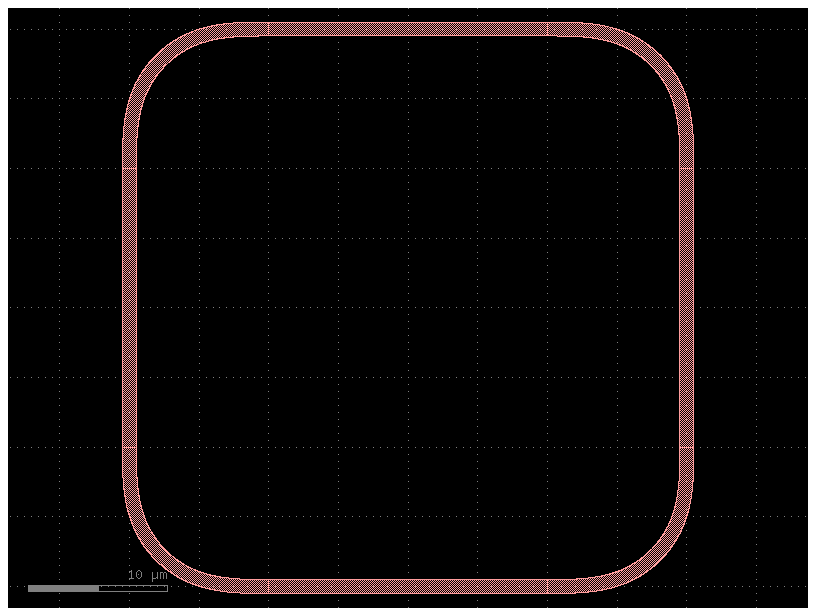

In [254]:
if __name__ == "__main__":
    ring = ring_resonator_euler(length_x=20, length_y=20, width=1, radius=10)
    ring.show()
    ring.plot()

## Input output coupler 1

In [255]:
#@gf.cell
def io_Coupler_1(L, width, radius):
    x1 = cross_section(width=width, layer=(1, 0))
    c1 = gf.Component(name=f"io_Coupler_1_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    s = straight(length=L, cross_section=x1)
    s_long = straight(length=100, cross_section=x1)
    b = bend_euler(radius=radius, cross_section=x1, npoints=3600)

    s1 = c1 << s
    s2 = c1 << s_long
    s3 = c1 << s_long

    b1 = c1 << b
    b2 = c1 << b

    b1.connect("o2", s1.ports["o2"])
    b2.connect("o1", s1.ports["o1"])
    s2.connect("o1", b2.ports["o2"])
    s3.connect("o1", b1.ports["o1"])

    c1.add_port(name="p1", port=s2.ports["o2"])
    c1.add_port(name="p2", port=s3.ports["o2"])

    return c1

21:07:32 | WARNING  | Could not connect to klive server
["Port(self.name='p1', self.width=800, trans=r270 *1 -20,-120, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=800, trans=r270 *1 230,-120, layer=WG (1/0), port_type=optical)"]


/tmp/ipython-input-3758061757.py:3: UserWarning: No project dir found.
  io1.show()


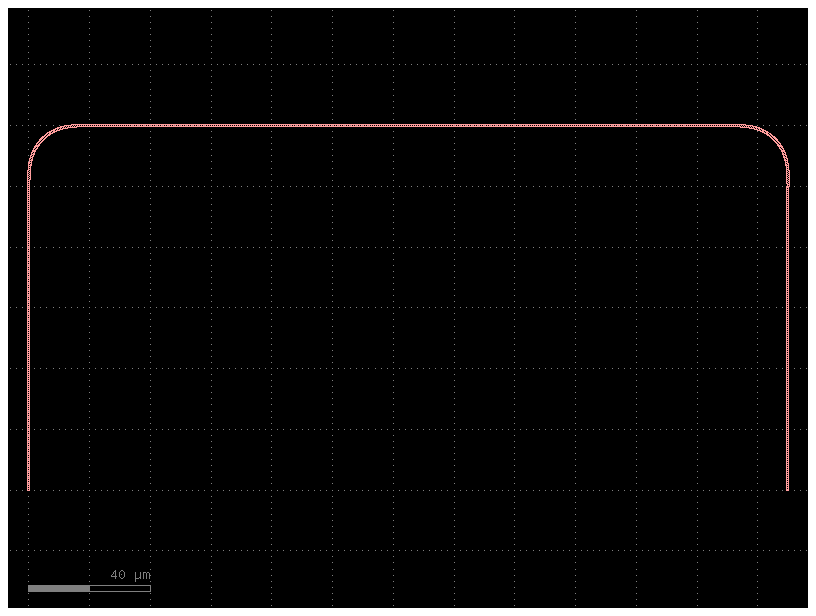

In [256]:
if __name__ == "__main__":
    io1 = io_Coupler_1(L=210, width=0.8, radius=20)
    io1.show()
    io1.plot()
    print(io1.ports)
    io1.draw_ports()
    #io1.write_gds("test.gds")

In [257]:
#@gf.cell
def io_Coupler_1_v2(L, width, radius):
    x1 = cross_section(width=width, layer=(1, 0))
    c1 = gf.Component(name=f"io_Coupler_1_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    s = straight(length=L, cross_section=x1)
    s_long = straight(length=100, cross_section=x1)
    b = bend_euler(radius=radius, cross_section=x1, npoints=3600)

    s1 = c1 << s
    s2 = c1 << s_long
    s3 = c1 << s_long

    b1 = c1 << b
    b2 = c1 << b
    b3 = c1 << b

    b1.connect("o2", s1.ports["o2"])
    b2.connect("o1", s1.ports["o1"])
    s2.connect("o1", b2.ports["o2"])
    s3.connect("o1", b1.ports["o1"])
    b3.connect("o1", s3.ports["o2"])

    c1.add_port(name="p1", port=s2.ports["o2"])
    c1.add_port(name="p2", port=b3.ports["o2"])

    return c1

21:07:32 | WARNING  | Could not connect to klive server
["Port(self.name='p1', self.width=800, trans=r270 *1 -20,-120, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=800, trans=r0 *1 250,-140, layer=WG (1/0), port_type=optical)"]


/tmp/ipython-input-2708891703.py:3: UserWarning: No project dir found.
  io1.show()


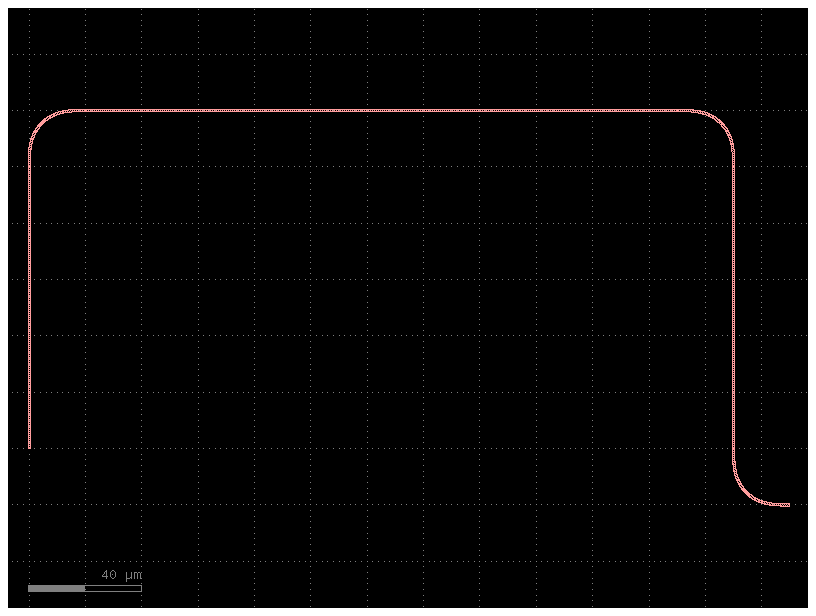

In [258]:
if __name__ == "__main__":
    io1 = io_Coupler_1_v2(L=210, width=0.8, radius=20)
    io1.show()
    io1.plot()
    print(io1.ports)
    io1.draw_ports()
    #io1.write_gds("test.gds")

In [259]:
#@gf.cell
def io_Coupler_1_v3(L, width, radius):
    x1 = cross_section(width=width, layer=(1, 0))
    c1 = gf.Component(name=f"io_Coupler_1_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    s = straight(length=L, cross_section=x1)
    s_short = straight(length=48, cross_section=x1)
    s_long = straight(length=100, cross_section=x1)
    b = bend_euler(radius=radius, cross_section=x1, npoints=3600)

    s1 = c1 << s
    s2 = c1 << s_long
    s3 = c1 << s_short

    b1 = c1 << b
    b2 = c1 << b
    b3 = c1 << b
    b4 = c1 << b

    b1.connect("o2", s1.ports["o2"])
    b2.connect("o1", s1.ports["o1"])
    s2.connect("o1", b2.ports["o2"])
    s3.connect("o1", b1.ports["o1"])
    b3.connect("o1", s3.ports["o2"])
    b4.connect("o1", s2.ports["o2"])

    c1.add_port(name="p1", port=b4.ports["o2"])
    c1.add_port(name="p2", port=b3.ports["o2"])

    return c1

21:07:32 | WARNING  | Could not connect to klive server
["Port(self.name='p1', self.width=800, trans=r0 *1 0,-140, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=800, trans=r0 *1 250,-88, layer=WG (1/0), port_type=optical)"]


/tmp/ipython-input-900400293.py:3: UserWarning: No project dir found.
  io1.show()


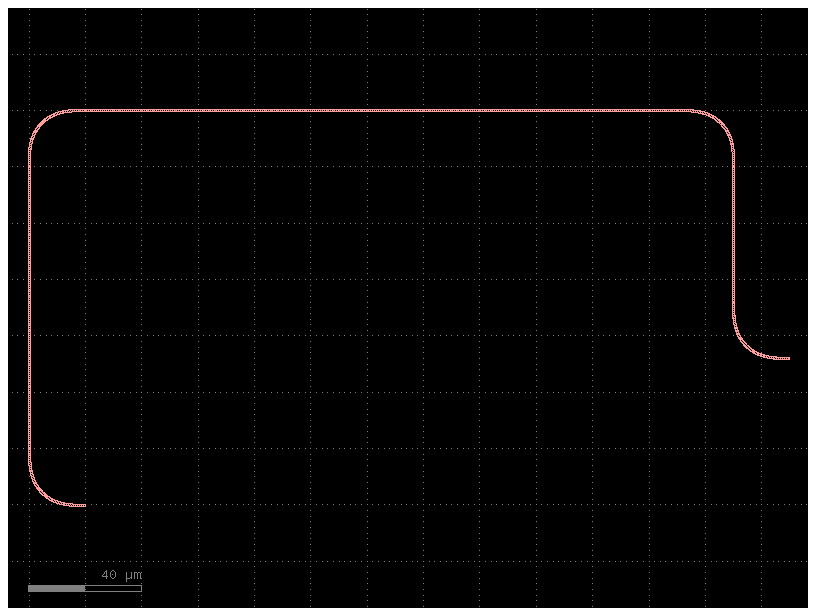

In [260]:
if __name__ == "__main__":
    io1 = io_Coupler_1_v3(L=210, width=0.8, radius=20)
    io1.show()
    io1.plot()
    print(io1.ports)
    io1.draw_ports()
    #io1.write_gds("test.gds")

## Input output coupler 2

In [261]:
#@gf.cell
def io_Coupler_2(L, width, radius):

    x1 = cross_section(width=width, layer=(1, 0))

    c1 = gf.Component(name=f"io_Coupler_2_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    delta = 50
    wg_length = 10

    s = gf.components.straight(length=100, cross_section=x1)
    s_long = gf.components.straight(length=L, cross_section=x1)

    b = gf.components.bend_euler(radius=radius, cross_section=x1, npoints=3600)

    # Straight waveguides

    s1=c1 << s
    s2=c1 << s_long
    s3=c1 << s

    # Euler bends

    b1 = c1 << b
    b2 = c1 << b

    # Connect straight sections to bends

    s1.connect("o2", b1.ports["o2"])
    s2.connect("o1", b1.ports["o1"])
    b2.connect("o2", s2.ports["o2"])
    s3.connect("o1", b2.ports["o1"])

    c1.add_port(name="p1", port=s1.ports["o1"])
    c1.add_port(name="p2", port=s3.ports["o2"])

    return c1

21:07:33 | WARNING  | Could not connect to klive server
["Port(self.name='p1', self.width=800, trans=r90 *1 20,120, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=800, trans=r90 *1 -230,120, layer=WG (1/0), port_type=optical)"]


/tmp/ipython-input-1827306331.py:3: UserWarning: No project dir found.
  io2.show()


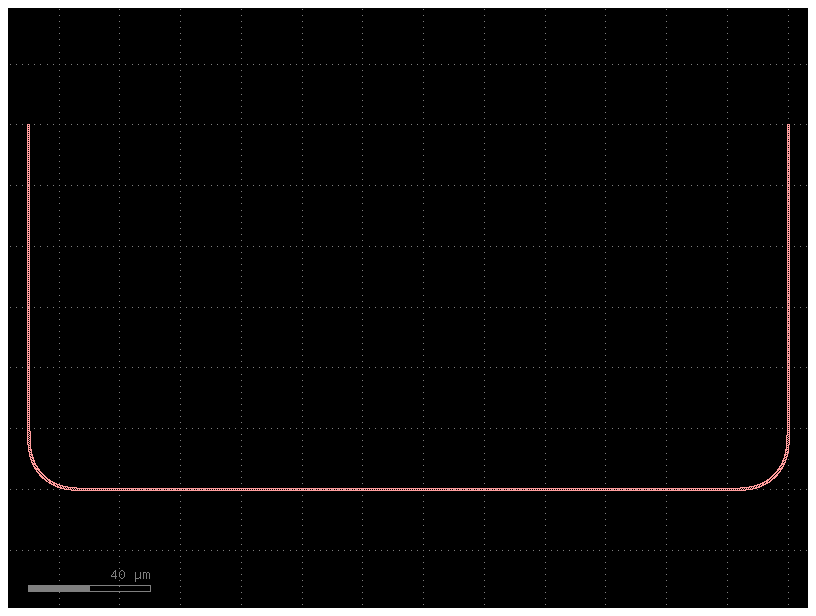

In [262]:
if __name__ == "__main__":
    io2 = io_Coupler_2(L=210, width=0.8, radius=20)
    io2.show()
    io2.plot()
    print(io2.ports)
    io2.draw_ports()
    #io2.write_gds("test.gds")

In [263]:
#@gf.cell
def io_Coupler_2_v2(L, width, radius, dx, dy):

    x1 = cross_section(width=width, layer=(1, 0))

    c1 = gf.Component(name=f"io_Coupler_2_L{L}_w{width}_r{radius}_{uuid.uuid4().hex[:6]}")

    s = gf.components.straight(length=50, cross_section=x1)
    s_long = gf.components.straight(length=L, cross_section=x1)
    s_dx = gf.components.straight(length=dx, cross_section=x1)
    s_dy = gf.components.straight(length=dy, cross_section=x1)

    b = gf.components.bend_euler(radius=radius, cross_section=x1, npoints=3600)

    # Straight waveguides

    s1 = c1 << s
    s2 = c1 << s_long
    s3 = c1 << s
    s4 = c1 << s_dx
    s5 = c1 << s_dy

    # Euler bends

    b1 = c1 << b
    b2 = c1 << b
    b3 = c1 << b
    b4 = c1 << b
    b5 = c1 << b
    b6 = c1 << b

    # Connect straight sections to bends

    s1.connect("o2", b1.ports["o2"])
    s2.connect("o1", b1.ports["o1"])
    b2.connect("o2", s2.ports["o2"])
    s3.connect("o1", b2.ports["o1"])
    b3.connect("o2", s1.ports["o1"])
    b4.connect("o1", s3.ports["o2"])
    s4.connect("o1", b3.ports["o1"])
    b5.connect("o2", s4.ports["o2"])
    s5.connect("o2", b5.ports["o1"])
    b6.connect("o1", s5.ports["o1"])

    c1.add_port(name="p1", port=b6.ports["o2"])
    c1.add_port(name="p2", port=b4.ports["o2"])

    return c1

21:07:33 | WARNING  | Could not connect to klive server
["Port(self.name='p1', self.width=800, trans=r0 *1 180,-150, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=800, trans=r180 *1 -250,90, layer=WG (1/0), port_type=optical)"]


/tmp/ipython-input-2985597930.py:3: UserWarning: No project dir found.
  io2.show()


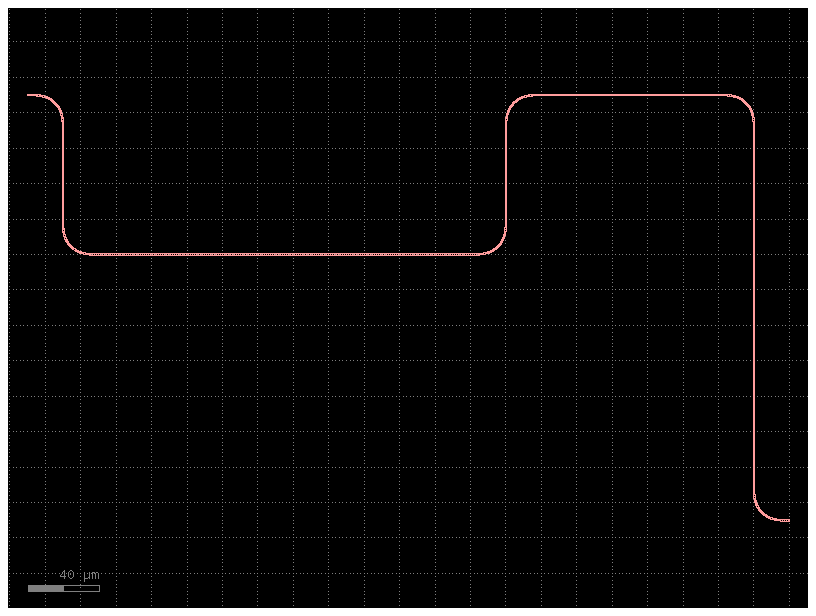

In [264]:
if __name__ == "__main__":
    io2 = io_Coupler_2_v2(L=210, width=0.8, radius=20, dx=100, dy=200)
    io2.show()
    io2.plot()
    print(io2.ports)
    io2.draw_ports()
    #io2.write_gds("test_port.gds")

## Add drop filter - chain of rings

In [265]:
#@gf.cell
def ring_chain(radius, L, width, latticeX, latticeY, N, gap, gap_fc):
    """Returns chain of rings.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size (>=1)
        gap: gap between rings
    """
    c = gf.Component(name=f"chain_{uuid.uuid4().hex[:6]}")

    if N == 1:
      shiftX = 0
    else:
      shiftX = 2 * radius + L + width + gap
    shiftY = 2 * radius + L + width + gap

    for i in range(0, N):
        xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
        xref.move([(latticeX), (latticeY + i * shiftY)])

    # Grating parameters

    L_coupler = L

    wr1 = c << io_Coupler_1_v2(L_coupler, width, radius)
    wr2 = c << io_Coupler_2(L_coupler, width, radius)
    wr1.move([latticeX - L_coupler, latticeY - gap_fc - width])
    wr2.move([latticeX, latticeY + L + 2 * radius + (N-1) * (2 * radius + L + gap + width) + gap_fc + width])

    c.add_port(name="p1", port=wr1.ports["p1"])
    c.add_port(name="p2", port=wr1.ports["p2"])
    c.add_port(name="p3", port=wr2.ports["p1"])
    c.add_port(name="p4", port=wr2.ports["p2"])

    return c


def ring_chain_all_pass(radius, L, width, latticeX, latticeY, N, gap, gap_fc):
    """Returns chain of rings.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size (>=1)
        gap: gap between rings
    """
    c = gf.Component(name=f"chain_{uuid.uuid4().hex[:6]}")

    if N == 1:
      shiftX = 0
    else:
      shiftX = 2 * radius + L + width + gap
    shiftY = 2 * radius + L + width + gap

    for i in range(0, N):
        xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
        xref.move([(latticeX), (latticeY + i * shiftY)])

    # Grating parameters

    L_coupler = L

    wr1 = c << io_Coupler_1_v2(L_coupler, width, radius)
    #wr2 = c << io_Coupler_2(L_coupler, width, radius)
    wr1.move([latticeX - L_coupler, latticeY - gap_fc - width])
    #wr2.move([latticeX, latticeY + L + 2 * radius + (N-1) * (2 * radius + L + gap + width) + gap_fc + width])

    c.add_port(name="p1", port=wr1.ports["p1"])
    c.add_port(name="p2", port=wr1.ports["p2"])
    #c.add_port(name="p3", port=wr2.ports["p1"])
    #c.add_port(name="p4", port=wr2.ports["p2"])

    return c

In [266]:
def circular_ring_chain_all_pass(radius, L, width, latticeX, latticeY, N, gap, gap_fc):
    """Returns chain of rings.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size (>=1)
        gap: gap between rings
    """
    c = gf.Component(name=f"chain_{uuid.uuid4().hex[:6]}")

    if N == 1:
      shiftX = 0
    else:
      shiftX = 2 * radius + L + width + gap
    shiftY = 2 * radius + L + width + gap

    for i in range(0, N):
        xref = c << gf.components.ring(radius=radius, width=width, angle_resolution=0.1, layer=(1,0), angle=360)
        # angle_resolution (float) – number of points per degree
        xref.move([(latticeX - L/2), (latticeY + i * shiftY + radius)])

    # Grating parameters

    L_coupler = L

    wr1 = c << io_Coupler_1_v2(L_coupler, width, 20)
    #wr2 = c << io_Coupler_2(L_coupler, width, radius)
    wr1.move([latticeX - L_coupler, latticeY - gap_fc - width])
    #wr2.move([latticeX, latticeY + L + 2 * radius + (N-1) * (2 * radius + L + gap + width) + gap_fc + width])

    c.add_port(name="p1", port=wr1.ports["p1"])
    c.add_port(name="p2", port=wr1.ports["p2"])
    #c.add_port(name="p3", port=wr2.ports["p1"])
    #c.add_port(name="p4", port=wr2.ports["p2"])

    return c

21:07:33 | WARNING  | Could not connect to klive server


/tmp/ipython-input-3625183546.py:23: UserWarning: No project dir found.
  chain.show()


PosixPath('test_ring.gds')

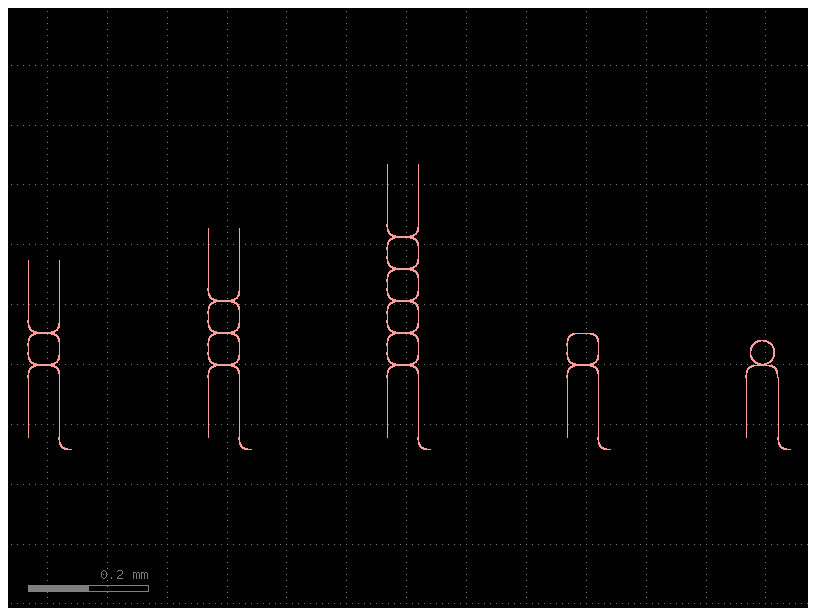

In [267]:
gf.clear_cache()
chain = gf.Component("chain")

x_shift = 300
rc1 = chain << ring_chain(20, 12, 1.2, 0, 0, 1, 0.2, 0.4)
rc2 = chain << ring_chain(20, 12, 1.2, x_shift, 0, 2, 0.2, 0.4)
rc3 = chain << ring_chain(20, 12, 1.2, 2 * x_shift, 0, 4, 0.2, 0.4)
rc4 = chain << ring_chain_all_pass(20, 12, 1.2, 3 * x_shift, 0, 1, 0.2, 0.4)
rc5 = chain << circular_ring_chain_all_pass(20, 12, 1.2, 4 * x_shift, 0, 1, 0.2, 0.4)

ring_chains = [rc1, rc2, rc3]

for i, rc in enumerate(ring_chains):
  for j in range(0, 4):
    chain.add_port(name=f"{rc.ports[j].name}", port=rc.ports[rc.ports[j].name])

ring_chains = [rc4, rc5]

for i, rc in enumerate(ring_chains):
  for j in range(0, 2):
    chain.add_port(name=f"{rc.ports[j].name}", port=rc.ports[rc.ports[j].name])

chain.show()
chain.plot()
#print(chain.ports)
chain.draw_ports()
chain.write_gds("test_ring.gds")

## AQHE / IQHE lattice

In [268]:
#@gf.cell
def topo_lattice(topology, radius, L, xi, alpha, width, latticeX, latticeY, N, gap, fc_gap):
  """Returns AQHE or IQHE lattice.

    Args:
        topology: topology of lattice (IQHE or AQHE)
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"QHE_{uuid.uuid4().hex[:6]}")

  shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
  shiftY = 2 * radius + L + width + gap

  xi = xi/2

  if topology == "IQHE":
    var_topology = 0
  elif topology == "AQHE":
    var_topology = 1
  else:
    raise ValueError("Topology must be IQHE or AQHE")

  for i in range(0, 2 * N - 1):
      for j in range(0, 2 * N - 1):
          if(var_topology == 0): ## IQHE
              #LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
              if((i%2 == 1) ^ (j%2 == 1)):
                if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
                  xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                  xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
                else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
                  xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                  xref.move([(latticeX + j * shiftX + alpha/2), (latticeY + i * shiftY)])
              elif((i%2 == 0) and (j%2 == 0)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
          elif(var_topology == 1):  ## AQHE
              #LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
              if((i%2 == 1) and (j%2 == 1)):
                #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                xref.move([(latticeX + j * (shiftX + 0) + alpha/2), (latticeY + i * shiftY)])
                #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
              #SITE RINGS, NO EXTRA LENGTH OR SHIFT
              if((i%2 == 1) and (j%2 == 0)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
              elif((i%2 == 0) and (j%2 == 1)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

  L_coupler = 12

  wr1 = c << io_Coupler_1_v3(L_coupler, width, radius)
  dx = 2 * (N-1) * (2 * radius + L + gap + width)
  dy = L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + 2 * fc_gap + 2 * width + 48 + 50 - L
  wr2 = c << io_Coupler_2_v2(L_coupler, width, radius, dx, dy)
  wr1.move([latticeX + var_topology*(2 * radius + L + gap + width) - L_coupler, latticeY - fc_gap - width])
  wr2.move([latticeX + var_topology*(2 * radius + L + gap + width), latticeY + L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + fc_gap + width])

  c.add_port(name="p1", port=wr1.ports["p1"])
  c.add_port(name="p2", port=wr1.ports["p2"])
  c.add_port(name="p3", port=wr2.ports["p1"])
  c.add_port(name="p4", port=wr2.ports["p2"])

  return c


  #@gf.cell
def topo_lattice_no_bus(topology, radius, L, xi, alpha, width, latticeX, latticeY, N, gap, fc_gap):
  """Returns AQHE or IQHE lattice.

    Args:
        topology: topology of lattice (IQHE or AQHE)
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"QHE_{uuid.uuid4().hex[:6]}")

  shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
  shiftY = 2 * radius + L + width + gap

  xi = xi/2

  if topology == "IQHE":
    var_topology = 0
  elif topology == "AQHE":
    var_topology = 1
  else:
    raise ValueError("Topology must be IQHE or AQHE")

  for i in range(0, 2 * N - 1):
      for j in range(0, 2 * N - 1):
          if(var_topology == 0): ## IQHE
              #LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
              if((i%2 == 1) ^ (j%2 == 1)):
                if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
                  xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                  xref.move([(latticeX + j * (shiftX + xi) + alpha/2), (latticeY + i * shiftY)])
                else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
                  xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                  xref.move([(latticeX + j * shiftX + alpha/2), (latticeY + i * shiftY)])
              elif((i%2 == 0) and (j%2 == 0)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
          elif(var_topology == 1):  ## AQHE
              #LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
              if((i%2 == 1) and (j%2 == 1)):
                #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
                xref.move([(latticeX + j * (shiftX + 0) + alpha/2), (latticeY + i * shiftY)])
                #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
              #SITE RINGS, NO EXTRA LENGTH OR SHIFT
              if((i%2 == 1) and (j%2 == 0)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])
              elif((i%2 == 0) and (j%2 == 1)):
                xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
                xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

  return c

21:07:34 | WARNING  | Could not connect to klive server


/tmp/ipython-input-3845181110.py:16: UserWarning: No project dir found.
  qhe.show()


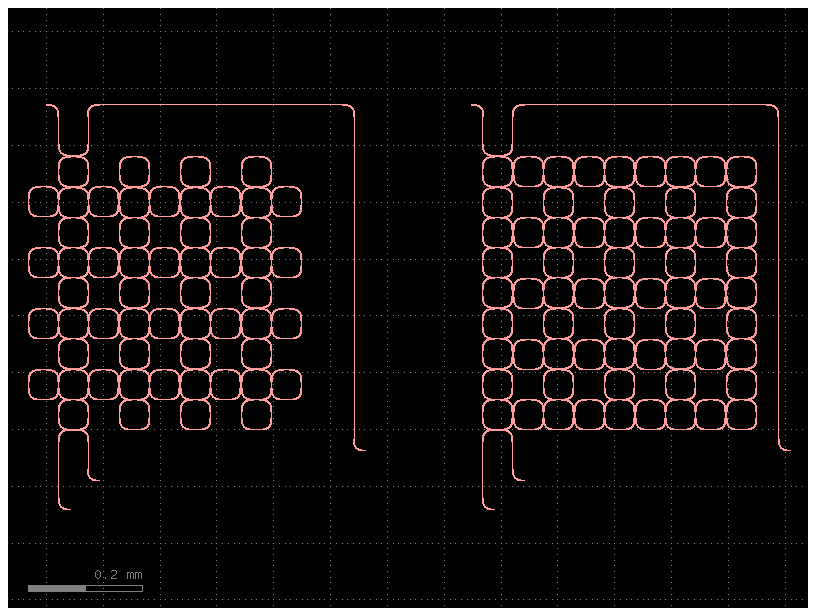

In [269]:
gf.clear_cache()

qhe = gf.Component("qhe")

x_shift = 800
#topo_lattice(topology, radius, L, xi, alpha, width, latticeX, latticeY, N, gap, fc_gap)
qhe1 = qhe << topo_lattice("AQHE", 20, 12, 0, 0.220, 1.2, 0, 0, 5, 0.3, 0.350)
qhe2 = qhe << topo_lattice("IQHE", 20, 12, 0.110, 0.220, 1.2, x_shift, 0, 5, 0.3, 0.350)

qhe_devices = [qhe1, qhe2]

for i, rc in enumerate(qhe_devices):
  for j in range(0, 4):
    qhe.add_port(name=f"{rc.ports[j].name}", port=rc.ports[rc.ports[j].name])

qhe.show()
qhe.plot()
#print(qhe.ports)
qhe.draw_ports()
#qhe.write_gds("test_qh.gds")

## IQHE molecule

In [270]:
#@gf.cell
def topo_lattice_molecule(radius, L, xi, alpha, width, latticeX, latticeY, N, gap, fc_gap):
  """Returns AQHE or IQHE lattice.

    Args:
        topology: topology of lattice (IQHE or AQHE)
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: x position of lattice
        latticeY: y position of lattice
        N: lattice size
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"QHE_{uuid.uuid4().hex[:6]}")

  shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
  shiftY = 2 * radius + L + width + gap

  bl = c << topo_lattice_no_bus("IQHE", radius, L, xi, alpha, width, latticeX, latticeY, N, gap, fc_gap)
  tr = c << topo_lattice_no_bus("IQHE", radius, L, xi, alpha, width, latticeX + shiftX*(2*N-2), latticeY + shiftY*(2*N-2), N, gap, fc_gap)

  L_coupler = L

  wr1 = c << io_Coupler_1_v3(L_coupler, width, radius)
  wr1.rotate(90)
  wr1.move([shiftX*(4*N-4) - radius - gap + fc_gap, shiftY*(4*N-4) + radius + fc_gap + width])
  dx = 4 * (N-1) * (2 * radius + L + gap + width)
  dy = L + 2 * radius + 4 * (N-1) * (2 * radius + L + gap + width) + 2 * fc_gap + 2 * width + 48 + 50 - L
  wr2 = c << io_Coupler_2_v2(L_coupler, width, radius, dx, dy)
  wr2.rotate(90)
  wr2.move([-shiftX - L - radius - fc_gap - width + alpha/2, -shiftY*(2*N-2) - radius - width - fc_gap])

  wr1.move([latticeX + (2 * radius + L + gap + width) - L_coupler, latticeY - fc_gap - width])
  wr2.move([latticeX + (2 * radius + L + gap + width), latticeY + L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + fc_gap + width])

  c.add_port(name="p1", port=wr1.ports["p1"])
  c.add_port(name="p2", port=wr1.ports["p2"])
  c.add_port(name="p3", port=wr2.ports["p1"])
  c.add_port(name="p4", port=wr2.ports["p2"])

  return c

21:07:35 | WARNING  | Could not connect to klive server


/tmp/ipython-input-914055720.py:14: UserWarning: No project dir found.
  qhe.show()


PosixPath('test_molecule.gds')

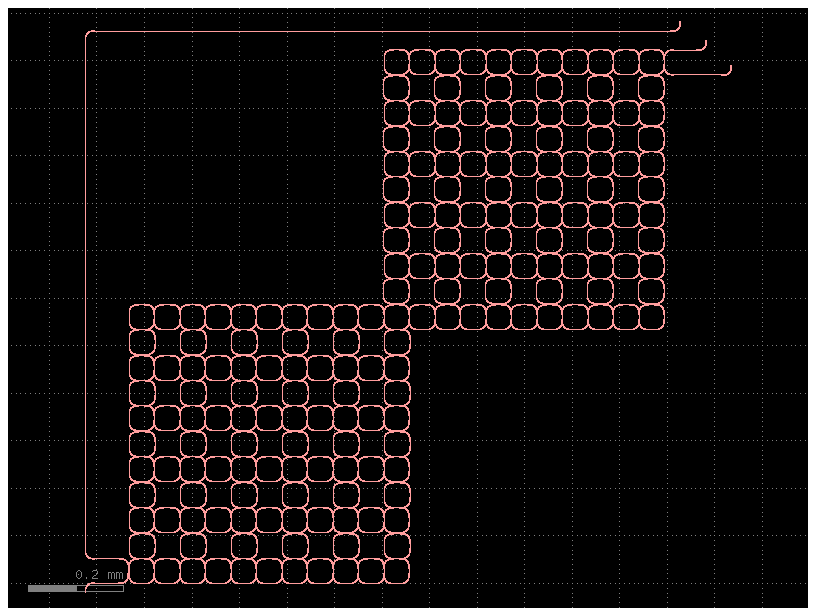

In [271]:
gf.clear_cache()

qhe = gf.Component("qhe")

x_shift = 800
qhe1 = qhe << topo_lattice_molecule(20, 12, 0.110, 0.220, 1.2, 0, 0, 6, 0.3, 0.3)

qhe_devices = [qhe1]

for i, rc in enumerate(qhe_devices):
  for j in range(0, 4):
    qhe.add_port(name=f"{rc.ports[j].name}", port=rc.ports[rc.ports[j].name])

qhe.show()
qhe.plot()
qhe.draw_ports()
qhe.write_gds("test_molecule.gds")

## IQHE - ring of rings

In [272]:
#@gf.cell
def IQHE_ROR(radius, L, xi, alpha, width, latticeX, latticeY, N, N_edge, gap, fc_gap):
  """Returns IQHE lattice.

    Args:
        radius: Euler bend radius
        L: length of straight section of racetrack
        xi: odd row link rings get extra shift xi each column
        alpha: x-dimension of link-ring is longer than L by alpha
        width: waveguide width
        latticeX: #columns in chip
        latticeY: #rows in chip
        N: lattice size
        N_edge: thickness of edge in # of plaquettes (>=0)
        gap: gap between rings
        fc_gap: gap between ring and i/o fiber coupler
    """
  c = gf.Component(name=f"IQHE_{uuid.uuid4().hex[:6]}")

  for i in range(0, (2 * N_edge + 1)):
      for j in range(0, 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  for i in range(2 * N - 1 - (2 * N_edge + 1), 2 * N - 1):
      for j in range(0, 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  for i in range(0, 2 * N - 1):
      for j in range(0, (2 * N_edge + 1)):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])


  for i in range(0, 2 * N - 1):
      for j in range(2 * N - 1 - (2 * N_edge + 1), 2 * N - 1):
        shiftX = 2 * radius + L + width + gap + alpha/2 #compensate for the longer link rings
        shiftY = 2 * radius + L + width + gap

        ### LINK RING LOOP - X LENGTH IS INCREASED BY ALPHA
        if((i%2 == 1) ^ (j%2 == 1)):
          if(j%2 == 0): #ODD ROW LINK RINGS GET EXTRA SHIFT XI EACH COLUMN
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * (shiftX + xi) + alpha/2),(latticeY + i * shiftY)])
          else: #EVEN ROW LINK RINGS ARE IN LINE WITH SITE RINGS AND GET NO EXTRA SHIFT
            xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L+alpha, length_y=L)
            xref.move([(latticeX + j * shiftX + alpha/2),(latticeY + i * shiftY)])
        elif((i%2 == 0) and (j%2 == 0)):
          xref = c << ring_resonator_euler(radius=radius, width=width, length_x=L, length_y=L)
          xref.move([(latticeX + j * shiftX), (latticeY + i * shiftY)])

  L_coupler = 12

  dx = 2 * (N-1) * (2 * radius + L + gap + width)
  dy = L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + 2 * fc_gap + 2 * width + 48 + 50 - L

  wr1 = c << io_Coupler_1_v3(L_coupler, width, radius)
  wr2 = c << io_Coupler_2_v2(L_coupler, width, radius, dx, dy)
  wr1.move([latticeX - L_coupler, latticeY - fc_gap - width])
  wr2.move([latticeX, latticeY + L + 2 * radius + 2 * (N-1) * (2 * radius + L + gap + width) + fc_gap + width])

  c.add_port(name="p1", port=wr1.ports["p1"])
  c.add_port(name="p2", port=wr1.ports["p2"])
  c.add_port(name="p3", port=wr2.ports["p1"])
  c.add_port(name="p4", port=wr2.ports["p2"])

  return c

21:07:35 | WARNING  | Could not connect to klive server
["Port(self.name='p1', self.width=1200, trans=r0 *1 -12,-141.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=1200, trans=r0 *1 40,-89.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p3', self.width=1200, trans=r0 *1 827.6,-37.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p4', self.width=1200, trans=r180 *1 -52,891, layer=WG (1/0), port_type=optical)", "Port(self.name='p1', self.width=1200, trans=r0 *1 1488,-141.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=1200, trans=r0 *1 1540,-89.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p3', self.width=1200, trans=r0 *1 2327.6,-37.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p4', self.width=1200, trans=r180 *1 1448,891, layer=WG (1/0), port_type=optical)", "Port(self.name='p1', self.width=1200, trans=r0 *1 2988,-141.4, layer=WG (1/0), port_type=optical)", "Port(self.name='p2', self.width=1200, tr

/tmp/ipython-input-2046594385.py:17: UserWarning: No project dir found.
  iqhe_ror.show()


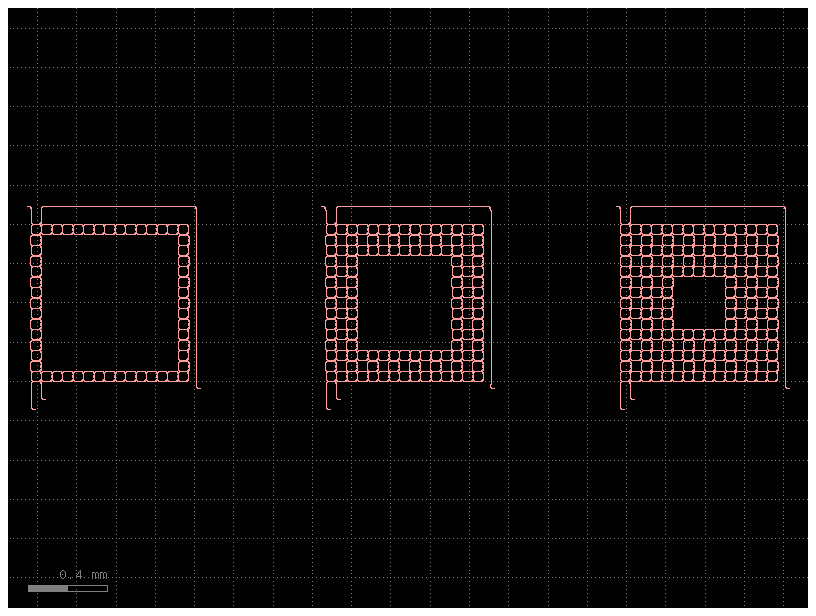

In [273]:
gf.clear_cache()
iqhe_ror = gf.Component("iqhe_ror")

x_shift = 1500

iqhe_ror1 = iqhe_ror << IQHE_ROR(20, 12, 0.1, 0.2, 1.2, 0, 0, 8, 0, 0.2, 0.2)
iqhe_ror2 = iqhe_ror << IQHE_ROR(20, 12, 0.1, 0.2, 1.2, x_shift, 0, 8, 1, 0.2, 0.2)
iqhe_ror3 = iqhe_ror << IQHE_ROR(20, 12, 0.1, 0.2, 1.2, 2*x_shift, 0, 8, 2, 0.2, 0.2)

iqhe_ror_devices = [iqhe_ror1, iqhe_ror2, iqhe_ror3]

for i, rc in enumerate(iqhe_ror_devices):
  for j in range(0, 4):
    #iqhe_ror.add_port(name=f"iqhe_ror{i}_{rc.ports[j].name}", port=rc.ports[rc.ports[j].name])
    iqhe_ror.add_port(name=f"{rc.ports[j].name}", port=rc.ports[rc.ports[j].name])

iqhe_ror.show()
iqhe_ror.plot()
print(iqhe_ror.ports)
iqhe_ror.draw_ports()
#iqhe_ror.write_gds("test_ror.gds")

## Ligentec edge coupler

In [274]:
from ligentec.an800.cells import AN800BB_EdgeCoupler_Lensed_C

In [275]:
#@gf.cell
def tapered_edge_coupler(
    length_taper: float,
    length_straight: float,
    width1: float,
    width_EdgeCoupler: float
) -> gf.Component:

    """Creates a custom edge coupler with a taper and a straight section."""

    c = gf.Component()

    # Build taper (edge coupler)
    taper = AN800BB_EdgeCoupler_Lensed_C(width_EdgeCoupler)

    taper_ref = c << taper

    # Define input/output ports for this composite component
    c.add_port("o1", port=taper.ports["o1"])  # Wide end (chip edge)

    return c

PosixPath('test_ec.gds')

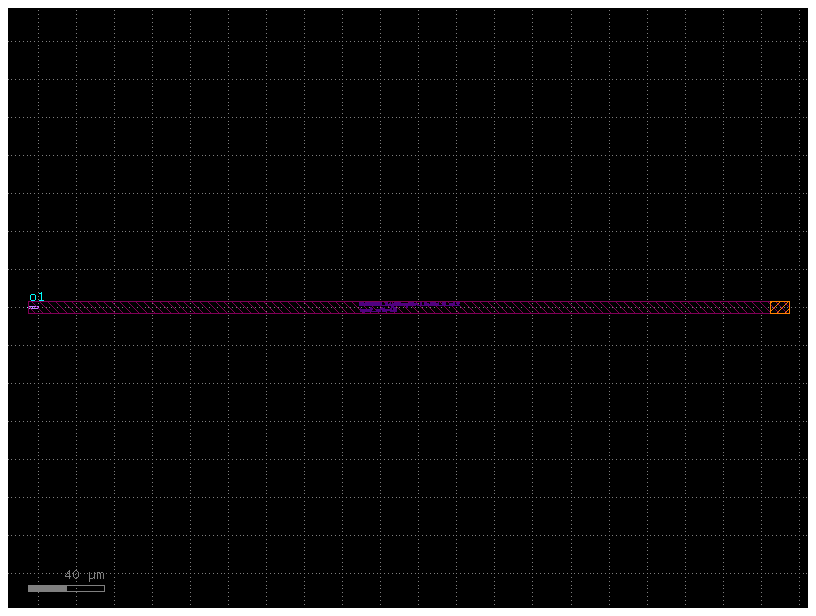

In [276]:
width_EdgeCoupler = 1.2
length_taper = 400
length_straight = 100 - 105
width1 = 1.2
width2 = 1.2

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width_EdgeCoupler)

c_ec.draw_ports()
c_ec.plot()
c_ec.write_gds("test_ec.gds")

# Chip design

## Chip parameters

In [277]:
edge_x = -200

gf.clear_cache()
c_QHE = gf.Component("QHE")

# AQHE lattice parameters

width = 1.2
alpha = 0.220
xi = 0.110
N = 8
radius = 20
R = 20
L1 = 12

# Chip design parameters

num_J = 8
num_cols = 1

gap1 = np.linspace(0.250, 0.600, num_J, endpoint=True)

gap_fc = 0.350

latticeX = 1300
latticeY = 3200

edge_couplers = []
devices = []

######################################## Chip dimension ################################################

chip_x = 10500
chip_y = 4850

x_offset = -3500
y_offset = -1000

chip = c_QHE << gf.components.rectangle(size=(chip_x, chip_y), layer=(2, 0))
chip.move([x_offset+400+2820, y_offset])

xs = cross_section(width=1.2, layer=(1, 0))
xs2 = cross_section(width=1.2, layer=(2, 0))

In [278]:
layer_transitions = {
    (LAYER.WG,      LAYER.SLAB150): "taper_strip_to_slab150",
    (LAYER.SLAB150, LAYER.WG):      "taper_strip_to_slab150",
}

## Rings and wg

In [279]:
######################################## 1 Ring - High Q ################################################
## Device 1

xpos = 4810
ypos = 3200

col1 = []

for row in range(1):
    x = c_QHE << ring_chain_all_pass(radius, L1, width, xpos, ypos, 1, 0.35, 0.35)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]

ports1 = [*ports1]
ports2 = [*ports2]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_top
    x1.move([ports2[0].x - x1.x + 2 * L1 + radius, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route2_col1 = route_bundle(c_QHE, ports2, ports2_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


######################################## 1 Ring - High Q ################################################
## Device 2

xpos = 4810 + 50
ypos = 3200 - 280

col1 = []

for row in range(1):
    x = c_QHE << ring_chain_all_pass(radius, L1, width, xpos, ypos, 1, 0.35, 0.35)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]

ports1 = [*ports1]
ports2 = [*ports2]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_top
    x1.move([ports2[0].x - x1.x + 2 * L1 + radius, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route2_col1 = route_bundle(c_QHE, ports2, ports2_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


######################################## 1 Ring - High Q ################################################
## Device 3

xpos = 4810 + 1440
ypos = 3200

col1 = []

for row in range(1):
    x = c_QHE << ring_chain_all_pass(radius, L1, width, xpos, ypos, 1, 0.35, 0.35)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]

ports1 = [*ports1]
ports2 = [*ports2]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_top
    x1.move([ports2[0].x - x1.x + 2 * L1 + radius, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route2_col1 = route_bundle(c_QHE, ports2, ports2_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


######################################## 1 Ring - High Q ################################################
## Device 4

xpos = 4810 + 1440 + 50
ypos = 3200 - 280

col1 = []

for row in range(1):
    x = c_QHE << ring_chain_all_pass(radius, L1, width, xpos, ypos, 1, 0.35, 0.35)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]

ports1 = [*ports1]
ports2 = [*ports2]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_top
    x1.move([ports2[0].x - x1.x + 2 * L1 + radius, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route2_col1 = route_bundle(c_QHE, ports2, ports2_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


######################################## 1 Ring - High Q ################################################
## Device 5

xpos = 4810 + 2840 + 95
ypos = 3200 + 370 - 200

col1 = []

for row in range(1):
    x = c_QHE << circular_ring_chain_all_pass(50, 100, 1.3, xpos, ypos, 1, 0.3, 0.3)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]

ports1 = [*ports1]
ports2 = [*ports2]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_top
    x1.move([ports2[0].x - x1.x + 2 * L1 + radius, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route2_col1 = route_bundle(c_QHE, ports2, ports2_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


######################################## 1 Ring - High Q ################################################
## Device 6

xpos = 4810 + 2840 + 50 + 440
ypos = 3200 - 280 + 380

col1 = []

for row in range(1):
    x = c_QHE << circular_ring_chain_all_pass(110, 200, 1.7, xpos, ypos, 1, 0.3, 0.3)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]

ports1 = [*ports1]
ports2 = [*ports2]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x - 240, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_top
    x1.move([ports2[0].x - x1.x + 2 * L1 + radius + 50, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route2_col1 = route_bundle(c_QHE, ports2, ports2_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

/usr/local/lib/python3.12/dist-packages/gdsfactory/components/bends/bend_euler.py:108: UserWarning: {'width': 1.2} ignored for cross_section 'xs_0b50dad6'
  )
/usr/local/lib/python3.12/dist-packages/gdsfactory/components/waveguides/straight.py:31: UserWarning: {'width': 1.2} ignored for cross_section 'xs_0b50dad6'
  x = gf.get_cross_section(cross_section, width=width)


### 1, 2, 6 rings

In [280]:
gap = [0.3, 0.4, 0.5]

######################################## 1 Ring ################################################
##Device 1
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 1, gap[0], gap_fc)
    x.move([-160,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 2
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 1, gap[1],gap_fc)
    x.move([0,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 3
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 1, gap[2], gap_fc)
    x.move([160*1,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

######################################## 2 Rings ################################################

##Device 4
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 2, gap[0], gap_fc)
    x.move([160*2,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 5
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 2, gap[1], gap_fc)
    x.move([160*3,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 6
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 2, gap[2], gap_fc)
    x.move([160*4,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

######################################## 6 Rings ################################################

##Device 7
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 6, gap[0], gap_fc)
    x.move([160*5,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 8
col1 = []

for row in range(1):
    x = c_QHE << ring_chain(radius, L1, width, 0, 0, 6, gap[1], gap_fc)
    x.move([160*6,0])
    col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports1 = [*ports1]
ports234 = [*ports2, *ports4, *ports3]

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports1[0].x - x1.x, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports234_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports234[1].x - x1.x + i*52, y_offset - (length_taper + length_straight) + chip_y])
    port234 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports234_ec.append(port234)

route1_col1 = route_bundle(c_QHE, ports1, ports1_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route234_col1 = route_bundle(c_QHE, ports234, ports234_ec, sort_ports=True, cross_section=xs, separation = 30.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

######################################## Waveguides ################################################

c_ec_bot = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)
c_ec_top = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(90)

ports1_ec = []

for i in range(2):
    x1 = c_QHE << c_ec_bot
    x1.move([x_offset + i*52 + 3468 + 160*7, y_offset + (length_taper + length_straight)])
    port1 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports1_ec.append(port1)

ports2_ec = []

for i in range(2):
    x1 = c_QHE << c_ec_top
    x1.move([x_offset + i*52 + 3468 + 160*7, y_offset - (length_taper + length_straight) + chip_y])
    port2 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports2_ec.append(port2)

route1_col1 = route_bundle(c_QHE, ports2_ec, ports1_ec, sort_ports=True, cross_section=xs2, separation = 30.0, radius=20)

/usr/local/lib/python3.12/dist-packages/gdsfactory/components/bends/bend_euler.py:108: UserWarning: {'width': 1.2} ignored for cross_section 'xs_bcceb957'
  )
/usr/local/lib/python3.12/dist-packages/gdsfactory/components/waveguides/straight.py:31: UserWarning: {'width': 1.2} ignored for cross_section 'xs_bcceb957'
  x = gf.get_cross_section(cross_section, width=width)


##IQH

In [281]:
######################################## Column 1 IQH ################################################
##Device 1

latticeX = 2800
latticeY = -1675.25
col1 = []

x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 4, 0.250, 0.500)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)


ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


##Device 2

latticeX -= 850
latticeY = - 1675.25 - 400
col1 = []

x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 7, 0.300, 0.300)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 3

latticeX -= 1164
latticeY = - 1675.25 - 2 * 400
col1 = []

x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 10, 0.300, 0.300)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 4

latticeX -= 1186
latticeY = - 1675.25 - 2*400 - 200
col1 = []

x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 10, 0.300, 0.250)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


## AQH

In [282]:
shiftX = 1750

######################################## Column 1 AQH ################################################
##Device 1

latticeX = 2800
latticeY = -1675.25 - shiftX
col1 = []

x = c_QHE << topo_lattice("AQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 4, 0.250, 0.500)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)


ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


##Device 2

latticeX -= 850
latticeY = - 1675.25 - 400 - shiftX
col1 = []

x = c_QHE << topo_lattice("AQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 7, 0.300, 0.300)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 3

latticeX -= 1164
latticeY = - 1675.25 - 2 * 400 - shiftX
col1 = []

x = c_QHE << topo_lattice("AQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 10, 0.300, 0.300)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

##Device 4

latticeX -= 1186
latticeY = - 1675.25 - 2*400 - 200 - shiftX
col1 = []

x = c_QHE << topo_lattice("AQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 10, 0.300, 0.250)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


## J sweep for IQH 6x6

In [283]:
shiftX = 2100

######################################## Column 1 IQH ################################################
##Device 1-4

latticeX = - 300
latticeY = - 1675.25 - 2*shiftX
col1 = []

for row in range(4):
    x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 6, gap1[row], gap_fc)
    x.drotate(angle=90)
    col1.append(x)
    latticeX += 800
    latticeY += 150

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)


ports4_ec = []
for i in range(4):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(12):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

######################################## Column 2 IQH ################################################
##Device 5-8

latticeX = - 300
latticeY = - 1675.25 - 2*shiftX - 1400
col1 = []

for row in range(4):
    x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 6, gap1[4+row], gap_fc)
    x.drotate(angle=90)
    col1.append(x)
    latticeX += 800
    latticeY += 150

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)


ports4_ec = []
for i in range(4):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(12):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


## Ring of rings

In [284]:
######################################## Column 1 ROR ################################################
##Device 1

latticeX = 2500
latticeY = - 8250
col1 = []

x = c_QHE << IQHE_ROR(radius, L1, 0, 0, width, latticeX, latticeY, 6, 0, 0.35, gap_fc)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)


ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)


##Device 2

latticeX -= 1150
latticeY = - 8250 - 500
col1 = []

x = c_QHE << IQHE_ROR(radius, L1, 0, 0, width, latticeX, latticeY, 10, 0, 0.45, gap_fc)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

## IQH molecule

In [285]:
'''##Device 3

latticeX -= 1150
latticeY = - 8250 - 650
col1 = []

x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 10, 0.300, 0.300)
x.drotate(angle=90)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20)'''

'##Device 3\n\nlatticeX -= 1150\nlatticeY = - 8250 - 650\ncol1 = []\n\nx = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 10, 0.300, 0.300)\nx.drotate(angle=90)\ncol1.append(x)\n\nports1 = [d.ports["p1"] for d in col1]\nports2 = [d.ports["p2"] for d in col1]\nports3 = [d.ports["p3"] for d in col1]\nports4 = [d.ports["p4"] for d in col1]\n\nports4 = [*ports4]\nports123 = [*ports1, *ports2, *ports3]\n\nc_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)\n\nports4_ec = []\nfor i in range(1):\n    x1 = c_QHE << c_ec_bot\n    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])\n    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])\n    ports4_ec.append(port4)\n\nports123_ec = []\nfor i in range(3):\n    x1 = c_QHE << c_ec_top\n    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])\n    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])\n    port

In [286]:
latticeX = 7820
latticeY = 50
col1 = []

x = c_QHE << topo_lattice_molecule(radius, L1, xi, alpha, width, latticeX, latticeY, 6, 0.300, 0.300)
col1.append(x)

ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(1):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(3):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

## J sweep IQH 4x4

In [287]:
##Column

latticeX = 0
latticeY = - 8900 - 1120
col1 = []

for row in range(4):
    x = c_QHE << topo_lattice("IQHE", radius, L1, xi, alpha, width, latticeX, latticeY, 4, gap1[2*row], gap_fc)
    x.drotate(angle=90)
    col1.append(x)
    latticeX += 800
    latticeY += 150


ports1 = [d.ports["p1"] for d in col1]
ports2 = [d.ports["p2"] for d in col1]
ports3 = [d.ports["p3"] for d in col1]
ports4 = [d.ports["p4"] for d in col1]

ports4 = [*ports4]
ports123 = [*ports1, *ports2, *ports3]

c_ec = tapered_edge_coupler(length_taper, length_straight, width1, width2).drotate(270)

ports4_ec = []
for i in range(4):
    x1 = c_QHE << c_ec_bot
    x1.move([ports4[i].x - x1.x, y_offset + (length_taper + length_straight)])
    port4 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports4_ec.append(port4)

ports123_ec = []
for i in range(12):
    x1 = c_QHE << c_ec_top
    x1.move([ports123[i].x - x1.x, y_offset - (length_taper + length_straight) + chip_y])
    port123 = c_QHE.add_port(name=f"o1_{i}", port=x1.ports["o1"])
    ports123_ec.append(port123)

route4_col1 = route_bundle(c_QHE, ports4, ports4_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)
route123_col1 = route_bundle(c_QHE, ports123, ports123_ec, sort_ports=True, cross_section=xs, separation = 40.0, radius=20, auto_taper=False, layer_transitions=layer_transitions)

# Plot

21:09:00 | WARNING  | Could not connect to klive server


/tmp/ipython-input-3186731199.py:2: UserWarning: No project dir found.
  c_QHE.show()


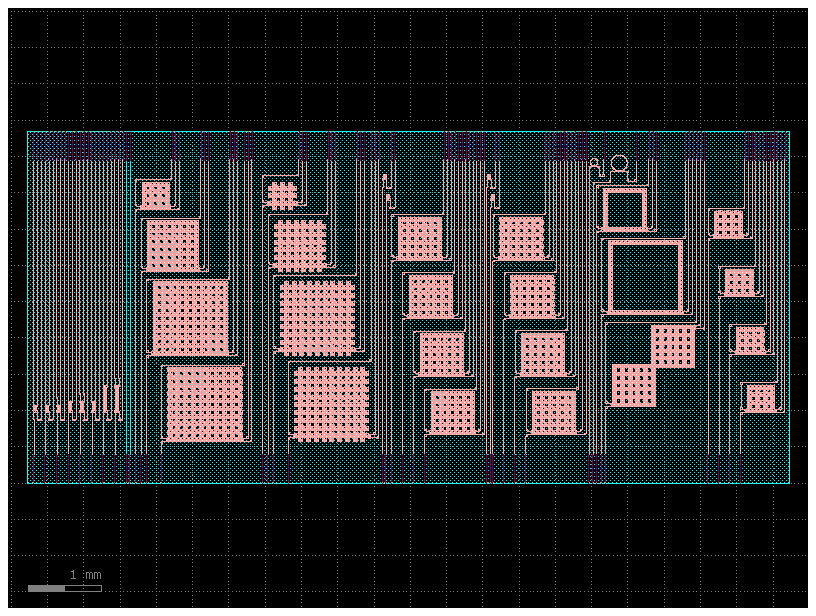

In [289]:
c_QHE.write_gds("test1.gds")
c_QHE.show()
c_QHE.plot()